# Denoising Auto Encoder for Corrupted MNIST Data

Created by: Eldion Vincent H. Bartolo

This Jupyter notebook builds a working model of a restoring autoencoder for corrupted MNIST. It is ran through Google Colab

Input: Input data is an MNIST image corrupted by a white square of at most 25% of the image area

Output: Restored MNIST image w/o the corrupting white square.

Notes:
1. Area of white square follows a uniform distribution over [6.25, 25] percent of the image area. That is, the dimension of the square should be sampled 
from: S = [7, 14] pixels.
2. Position of white square is randomly chosen. The x- and y-coordinates of the top-left corner are independently sampled from a uniform distribution 
over [0, 28 - S], where S is the length of the white square's side.

**Connect to Google Drive and Clone Github Repository**



In [12]:
# connect to google drive
from google.colab import drive
drive.mount('/content/gdrive')

# location of mnist_cnn.h5 for benchmarking
class_weight = '/content/gdrive/My Drive/saved_weights/mnist_cnn.h5'

# clone the public github repository : Original code: https://github.com/baudm/ee298z.git
!git clone https://github.com/ehbartolo/ee298Z_autoencoder.git
  
from ee298Z_autoencoder.hw2.transforms import corrupt_mnist_copy


Mounted at /content/gdrive
fatal: destination path 'ee298Z_autoencoder' already exists and is not an empty directory.


**Load MNIST Data and Generate Corrupted Data**

---

Corruption of data can is done thru the code from this public github repo:
https://github.com/baudm/ee298z.git


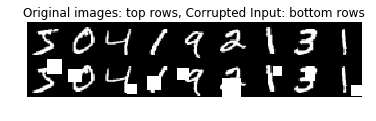

In [3]:
'''Trains a denoising autoencoder on MNIST dataset.
Denoising is one of the classic applications of autoencoders.
The denoising process removes unwanted noise that corrupted the
true signal.
Noise + Data ---> Denoising Autoencoder ---> Data
Given a training dataset of corrupted data as input and
true signal as output, a denoising autoencoder can recover the
hidden structure to generate clean data.
This example has modular design. The encoder, decoder and autoencoder
are 3 models that share weights. For example, after training the
autoencoder, the encoder can be used to  generate latent vectors
of input data for low-dim visualization like PCA or TSNE.
'''
                                                                    
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

np.random.seed(1337)

# load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train_noisy = corrupt_mnist_copy(x_train)
x_test_noisy = corrupt_mnist_copy(x_test)

# Display train and corrupted train data
# 1 set of images with 9 MNIST digits
# 1st rows - original images
# 2nd rows - images corrupted by noise
image_size = x_train.shape[1]
rows, cols = 1, 9
num = rows * cols
imgs = np.concatenate([x_train[:num], x_train_noisy[:num]])
imgs = imgs.reshape((rows * 2, cols, image_size, image_size))
imgs = np.vstack(np.split(imgs, rows, axis=1))
imgs = imgs.reshape((rows * 2, -1, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
imgs = (imgs * 1).astype(np.uint8)
plt.figure()
plt.axis('off')
plt.title('Original images: top rows, '
          'Corrupted Input: bottom rows')
plt.imshow(imgs, interpolation='none', cmap='gray')
Image.fromarray(imgs).save('corrupted_and_original.png')
plt.show()

**Normalize original and corrupted data**

---


Data should range from [0,1]

In [0]:
# reshape to (28, 28, 1) and normalize input images
image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train_noisy = np.reshape(x_train_noisy, [-1, image_size, image_size, 1])
x_test_noisy = np.reshape(x_test_noisy, [-1, image_size, image_size, 1])
x_train_noisy = x_train_noisy .astype('float32') / 255
x_test_noisy = x_test_noisy.astype('float32') / 255

# adding noise may exceed normalized pixel values>1.0 or <0.0
# clip pixel values >1.0 to 1.0 and <0.0 to 0.0
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)



**Build the Auto-Encoder Model**

![https://blog.keras.io/img/ae/autoencoder_schema.jpg](https://blog.keras.io/img/ae/autoencoder_schema.jpg)



1.   Build the Encoder using as stack of Conv2D(32)-Conv2D(64): CNN Layers activated by reLU and a dense layer on its output
2.   Build the Decoder using stack of Conv2DTranspose(64)-Conv2DTranspose(32) activated by ReLU and Conv2DTranspose(1) activated by sigmoid.
3. Build the Auto Encoder by feeding the output of Encoder to a Decoder



In [6]:
# network parameters
input_shape = (image_size, image_size, 1)
batch_size = 32
kernel_size = 3
latent_dim = 16
# encoder/decoder number of CNN layers and filters per layer
layer_filters = [32, 64]

# build the autoencoder model
# first build the encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs

# stack of Conv2D(32)-Conv2D(64)
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               activation='relu',
               padding='same')(x)

# shape info needed to build decoder model so we don't do hand computation
# the input to the decoder's first Conv2DTranspose will have this shape
# shape is (7, 7, 64) which can be processed by the decoder back to (28, 28, 1)
shape = K.int_shape(x)

# generate the latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

# instantiate encoder model
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

# build the decoder model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
# use the shape (7, 7, 64) that was earlier saved
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
# from vector to suitable shape for transposed conv
x = Reshape((shape[1], shape[2], shape[3]))(x)

# stack of Conv2DTranspose(64)-Conv2DTranspose(32)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=2,
                        activation='relu',
                        padding='same')(x)

# reconstruct the denoised input
outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          padding='same',
                          activation='sigmoid',
                          name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# autoencoder = encoder + decoder
# instantiate autoencoder model
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

# Mean Square Error (MSE) loss function, Adam optimizer
autoencoder.compile(loss='mse', optimizer='adam')

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_2 (Flatten)          (None, 3136)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 16)                50192     
Total params: 69,008
Trainable params: 69,008
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Sh

**Train the auto-encoder**


---

*   Train the auto-encoder for 10 epochs
*   Use the test data for validation
*   Plot the training and validation loss

We can see that after 2 epochs the reduction of training loss is already minimal










dict_keys(['val_loss', 'loss'])


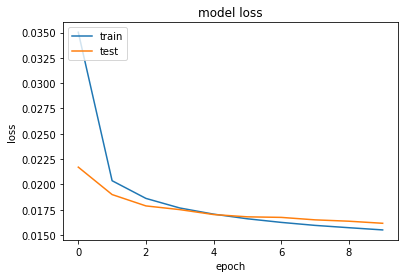

In [8]:
# train the autoencoder
history = autoencoder.fit(x_train_noisy,
                x_train,
                validation_data=(x_test_noisy, x_test),
                epochs=10,
                batch_size=batch_size, verbose=0)

# list all data in history
print(history.history.keys())
# summarize history for accuracy
#plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_accuracy'])
#plt.title('model accuracy')
#plt.ylabel('accuracy')
#plt.xlabel('epoch')
#plt.legend(['train', 'test'], loc='upper left')
#plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Denoise the corrupted test data**

---


The shown images consist of 3 sets of:





*   1st rows - original images
*   2nd rows - images corrupted by noise
*   3rd rows - denoised images

We can see that some images are not properly denoised such as the following:


*   The number '3' in 1st row is converted to '8' in 3rd row 
*   The number '5' in 4th row is converted to '8' in 6th row 

Some denoised images are blurry as compared to the original image










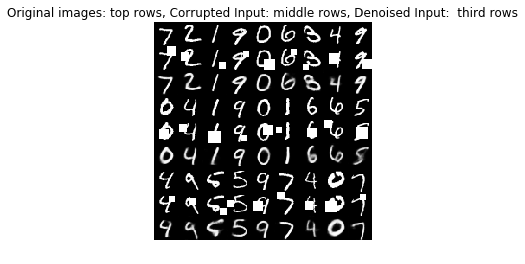

In [10]:
# predict the autoencoder output from corrupted test images
x_decoded = autoencoder.predict(x_test_noisy)

# 3 sets of images with 9 MNIST digits
# 1st rows - original images
# 2nd rows - images corrupted by noise
# 3rd rows - denoised images
rows, cols = 3, 9
num = rows * cols
imgs = np.concatenate([x_test[:num], x_test_noisy[:num], x_decoded[:num]])
imgs = imgs.reshape((rows * 3, cols, image_size, image_size))
imgs = np.vstack(np.split(imgs, rows, axis=1))
imgs = imgs.reshape((rows * 3, -1, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
imgs = (imgs * 255).astype(np.uint8)
plt.figure()
plt.axis('off')
plt.title('Original images: top rows, '
          'Corrupted Input: middle rows, '
          'Denoised Input:  third rows')
plt.imshow(imgs, interpolation='none', cmap='gray')
Image.fromarray(imgs).save('corrupted_and_denoised.png')
plt.show()

**Test the accuracy of AutoEncoder using a Bechmark code**


---
Classifier score: **94.26**   (Baseline: 78.36)

SSIM score: **89.65**         (Baseline: 75)

In [13]:
#test model:
from tensorflow.keras.datasets import mnist
from tensorflow.keras import backend as K
from ee298Z_autoencoder.hw2.benchmark_keras import test_model

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Scale to [0, 1]                      
x_test = x_test.astype(K.floatx()) / 255.

# model is your Keras model
# DO NOT convert y_test, i.e. don't use keras.utils.to_categorical()
test_model(autoencoder, x_test, y_test, class_weight, batch_size=100)

Classifier score: 94.26
SSIM score: 89.65
